In [139]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import json

import seaborn as sns
from pylab import rcParams
from matplotlib import rc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import pmdarima
from pmdarima.metrics import smape

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('formacao.csv', index_col=[0], parse_dates=[0])

# Dataset com feriados
portugal_holidays_csv = pd.read_csv('Holidays.csv')

In [3]:
with open('metgeo.json') as json_content:
    met_data = json.load(json_content)
json_content.close()

In [4]:
# Importar o dataset da meteorologia e mudar o nome da coluna time para "Data" para ajudar em operações join
met_df = pd.DataFrame.from_records(met_data['date'])
met_df = met_df.rename(columns={'time': 'Data'})
met_df['Data'] = met_df['Data'].apply(pd.to_datetime)
met_df = met_df.set_index('Data').sort_index(ascending=True)

# EDA

In [5]:
df.head()

,Produzida,Produzida.1,Específica,CO2 Evitado,
Data,,,,,
2021-02-01 01:00:00,0,0,0,,
2021-02-01 02:00:00,0,0,0,,
2021-02-01 03:00:00,0,0,0,,
2021-02-01 04:00:00,0,0,0,,
2021-02-01 05:00:00,0,0,0,,


In [6]:
portugal_holidays_csv.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-10-05


In [7]:
df.shape

(13870, 5)

In [8]:
pt_2021_holidays = portugal_holidays_csv[pd.to_datetime(portugal_holidays_csv['date']).dt.year==2021]
pt_2021_holidays.head()

,date
647,2021-01-01
648,2021-04-02
649,2021-04-04
650,2021-06-03
651,2021-10-05


In [9]:
pt_2021_holidays.tail()

,date
655,2021-05-01
656,2021-06-10
657,2021-08-15
658,2021-12-08
659,2021-12-25


In [10]:
met_df.head(25)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
Data,,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 01:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 02:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 03:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 04:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 05:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 06:00:00,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,None,NaN
2021-01-01 07:00:00,9.0,5.0,76.0,NaN,None,330.0,11.0,None,1017.0,None,NaN
2021-01-01 08:00:00,8.0,5.1,82.0,NaN,None,290.0,7.0,None,1018.0,None,17.0


In [11]:
# Let's use only tempetature

met_df = met_df[['temp']]

In [12]:
met_df.shape

(4824, 1)

In [13]:
# Nans Count
df.isna().sum()

 Produzida      0
 Produzida.1    0
 Específica     0
 CO2 Evitado    0
                0
dtype: int64

In [14]:
met_df.isna().sum()

temp    13
dtype: int64

In [15]:
# Duplicated Values (based on Date)
df[df.index.isin(df.index[df.index.duplicated()])]

,Produzida,Produzida.1,Específica,CO2 Evitado,
Data,,,,,
2021-10-31 01:00:00,0,0,0,,
2021-10-31 01:00:00,,0,,,


In [16]:
df.shape

(13870, 5)

In [17]:
# Helpful aux columns
def create_features(df):
    df['Date'] = df.index
    df.reset_index()
    df['Date_Parsed'] = df['Date'].dt.strftime('%Y-%m-%d')
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
#     df.drop('Date', axis=1, inplace=True)
    return df

df = create_features(df)
df.head()

,Produzida,Produzida.1,Específica,CO2 Evitado,,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Data,,,,,,,,,,,,,,,,
2021-02-01 01:00:00,0,0,0,,,2021-02-01 01:00:00,2021-02-01,1,0,1,2,2021,32,1,5,32.041667
2021-02-01 02:00:00,0,0,0,,,2021-02-01 02:00:00,2021-02-01,2,0,1,2,2021,32,1,5,32.083333
2021-02-01 03:00:00,0,0,0,,,2021-02-01 03:00:00,2021-02-01,3,0,1,2,2021,32,1,5,32.125000
2021-02-01 04:00:00,0,0,0,,,2021-02-01 04:00:00,2021-02-01,4,0,1,2,2021,32,1,5,32.166667
2021-02-01 05:00:00,0,0,0,,,2021-02-01 05:00:00,2021-02-01,5,0,1,2,2021,32,1,5,32.208333


In [18]:
df = df[df['Year']==2021]

In [19]:
np.unique(df['Year'])

array([2021], dtype=int64)

In [20]:
# Check if it's all ok in the dataset
days_of_week_by_month_2021 = df.groupby('Month')['DayOfYear'].agg(['min', 'max', 'count', 'nunique'])
days_of_week_by_month_2021

,min,max,count,nunique
Month,,,,
2,32,59,671,28
3,60,90,743,31
4,91,120,720,30
5,121,151,744,31
6,152,181,720,30
7,182,212,744,31
8,213,243,744,31
9,244,273,720,30
10,274,304,745,31


In [21]:
# perform the same aux 
met_df['Date'] = met_df.index
met_df['Year'] = met_df['Date'].dt.year
met_df['Month'] = met_df['Date'].dt.month
met_df['DayOfYear'] = met_df['Date'].dt.dayofyear

In [22]:
met_df = met_df[met_df['Year']==2021]
met_df = met_df[(met_df['Month'] >= 9) & (met_df['Month'] <= 12)]
# met_df = met_df.drop(['Year', 'Month', 'Date'], axis=1)

In [23]:
met_df_day_of_year_countage = met_df.groupby('Month')['DayOfYear'].agg(['min', 'max', 'count', 'nunique'])
met_df_day_of_year_countage

,min,max,count,nunique
Month,,,,
9,244,273,720,30
10,274,304,744,31
11,305,334,720,30
12,335,365,744,31


In [48]:
df = df[(df['Month'] >= 5) & (df['Month'] <= 12)]

## Let's find out what's missing in the dataset

## Deal with missing data

In [49]:
new_df = df.copy()

# ONLY IF WE GET ANY MISSING DATA

# Create hours missing in the dataset

# new_df = new_df.asfreq('H')
# new_df = create_features(new_df)
# new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

In [50]:
# new_df = new_df[(new_df['Month']>=3) & (new_df['Month']<=8)]

In [51]:
# Polynomial Interpolation (due to the data convex behaviour) in the missing data - Interpolate missing

# new_df[' Produzida'] = new_df[' Produzida'].interpolate(method='polynomial', order=2)
# new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Graphical Analysis

In [52]:
new_df[' Produzida'] = new_df[' Produzida'].str.strip()
new_df[' Produzida'].replace('', np.nan, inplace=True)

In [53]:
new_df = new_df.dropna()

new_df[' Produzida'] = new_df[' Produzida'].astype('float64')

Text(0, 0.5, ' Produzida')

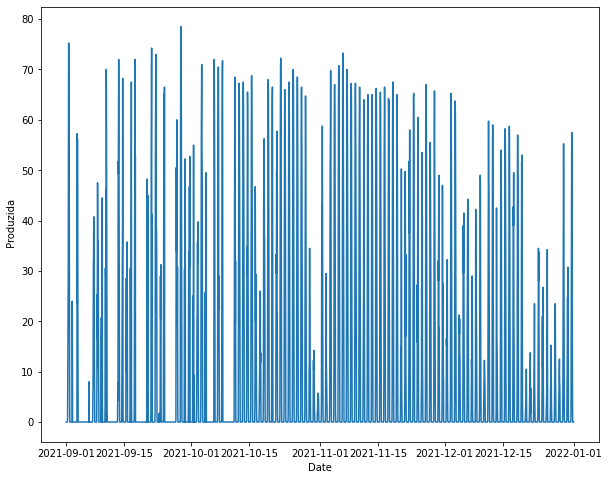

In [54]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# Interface Data
plt.plot(new_df.index, new_df[' Produzida'])
plt.xlabel("Date")
plt.ylabel(" Produzida")

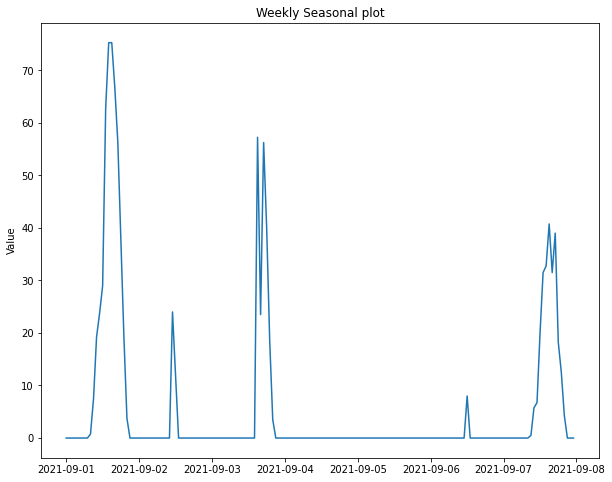

In [55]:
# First week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[:WEEK_END_INDEX], new_df[' Produzida'][:WEEK_END_INDEX])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

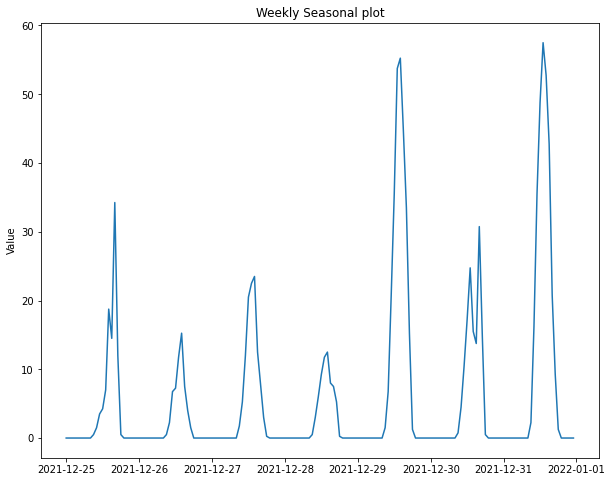

In [56]:
# Last week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[-WEEK_END_INDEX:], new_df[' Produzida'][-WEEK_END_INDEX:])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

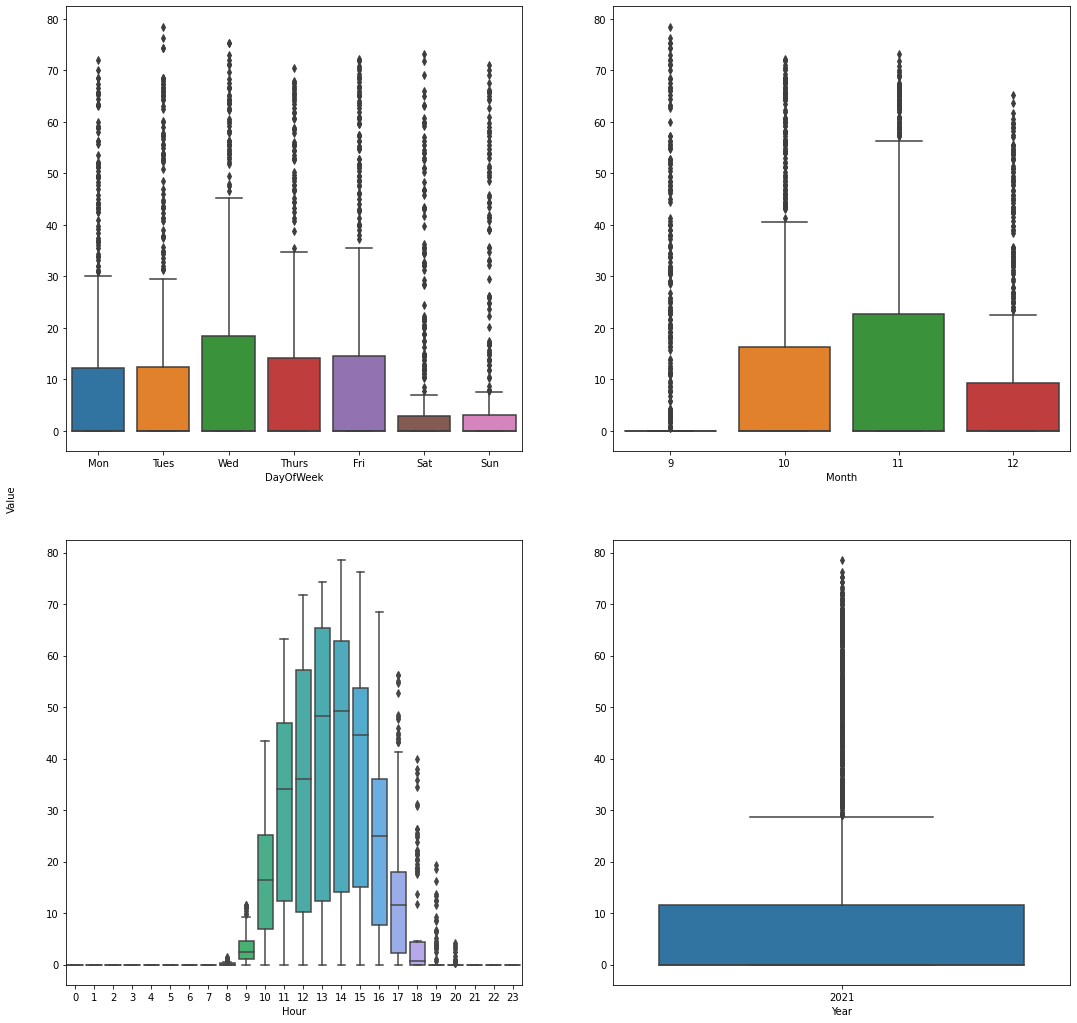

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=new_df.DayOfWeek, y=new_df[' Produzida'], ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=new_df.Month, y=new_df[' Produzida'], ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=new_df.Hour, y=new_df[' Produzida'], ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=new_df.Year, y=new_df[' Produzida'], ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Value', va='center', rotation='vertical')
plt.show()

# Several Outliers in Jan, Feb and Dec (Months with more energy consumption due to the cold/smaller days)
# Major problem -> between Mar and Oct (Much of the generated energy was not used)
# 9h - 18h - Tends to generate too much energy (Energy that isn't used by the costumer - Waste/Costly hours)

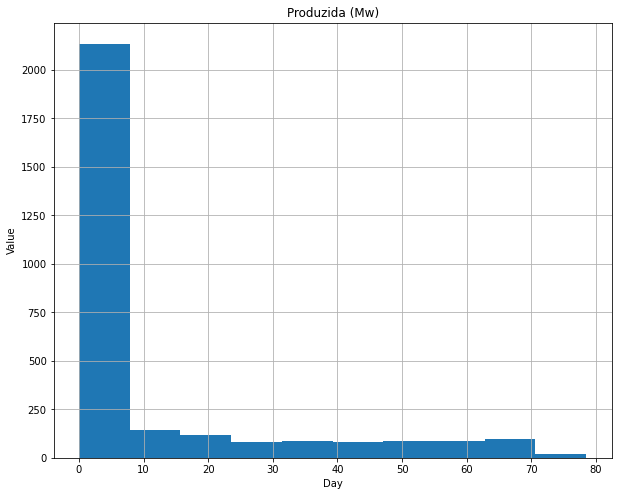

In [58]:
new_df[' Produzida'].hist()
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Produzida (Mw)')
plt.show()

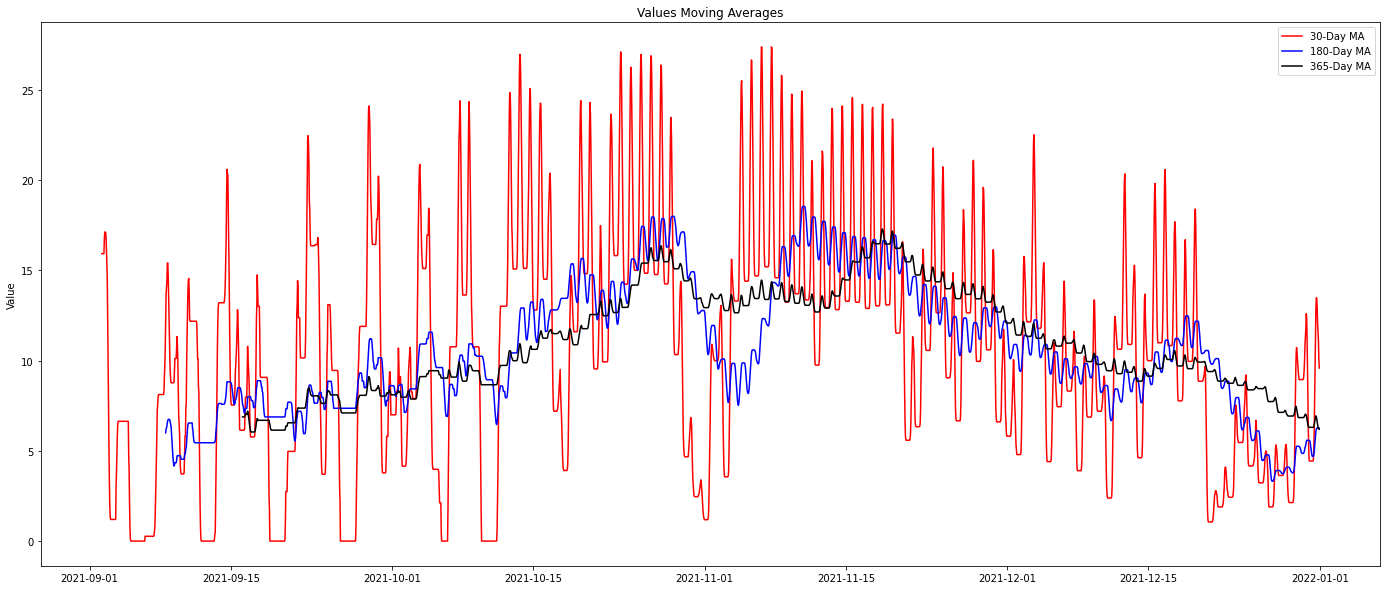

In [59]:
MONTH_PERIOD = 30
MIDYEAR_PERIOD = 182
YEAR_PERIOD = 365

month_roll = new_df[' Produzida'].rolling(MONTH_PERIOD).mean()
midyear_roll = new_df[' Produzida'].rolling(MIDYEAR_PERIOD).mean()
year_roll = new_df[' Produzida'].rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll, color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll, color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll, color='black', label='365-Day MA')
plt.title('Values Moving Averages')
plt.ylabel('Value')
plt.legend()
plt.show()

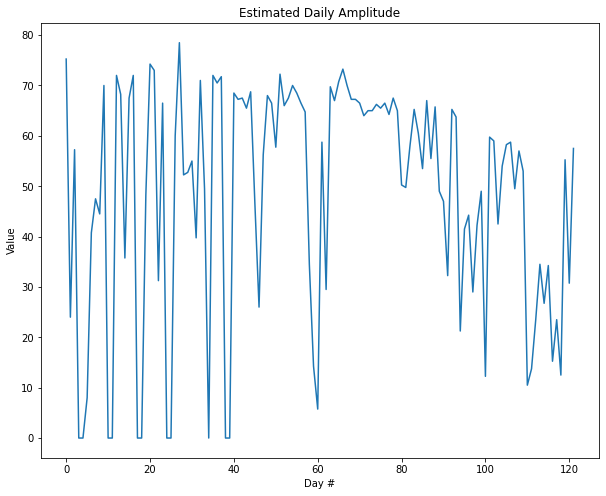

In [60]:
max_daily_vals = new_df.groupby(['Year', 'DayOfYear']).max()[' Produzida'].values
min_daily_vals = new_df.groupby(['Year', 'DayOfYear']).min()[' Produzida'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Value')
plt.title('Estimated Daily Amplitude')
plt.show()

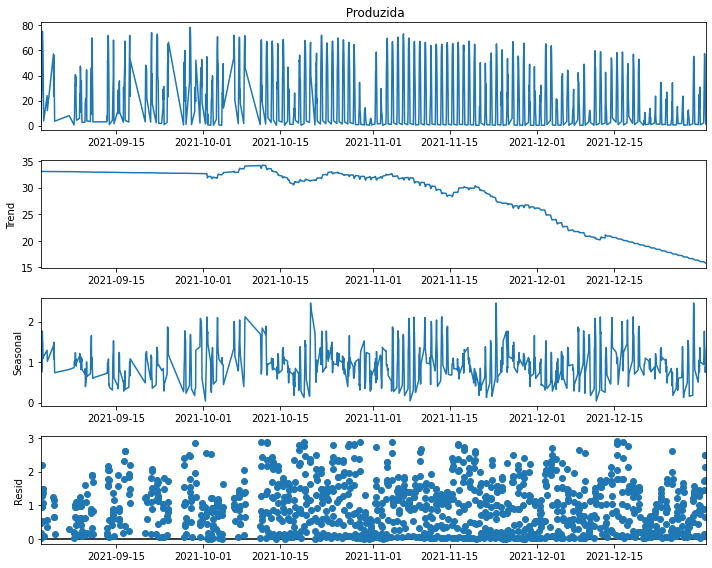

In [61]:
# Seasonal Decomposition
#  presence of some trend and seasonality

ANNUAL_PERIOD = 365
mult_decomp = seasonal_decompose(new_df[new_df[' Produzida']>0][' Produzida'].dropna(), model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

# Is the series stationary?

In [62]:
adf_result = adfuller(new_df[' Produzida'], regression='c') # with trend

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -6.642185082221886
p-value: 5.3752735713279104e-09


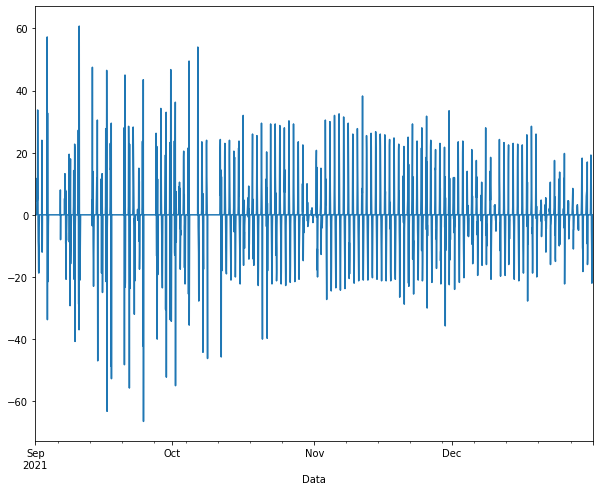

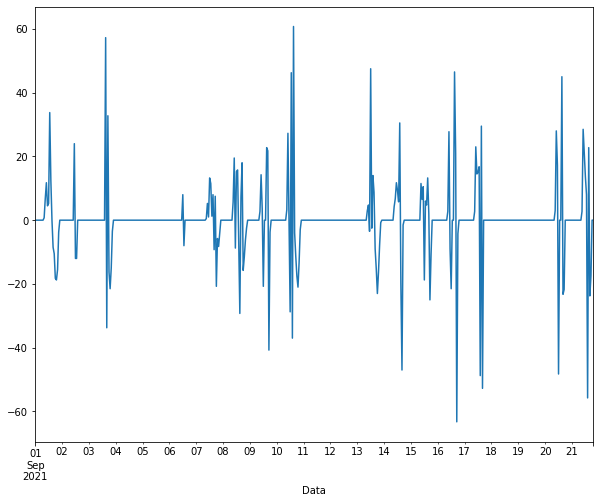

In [63]:
# first order diff
interface_first_difference = new_df[' Produzida'].diff()
interface_first_difference.plot()
plt.show()

interface_first_difference[:500].plot()
plt.show()

# We still see some seasonality

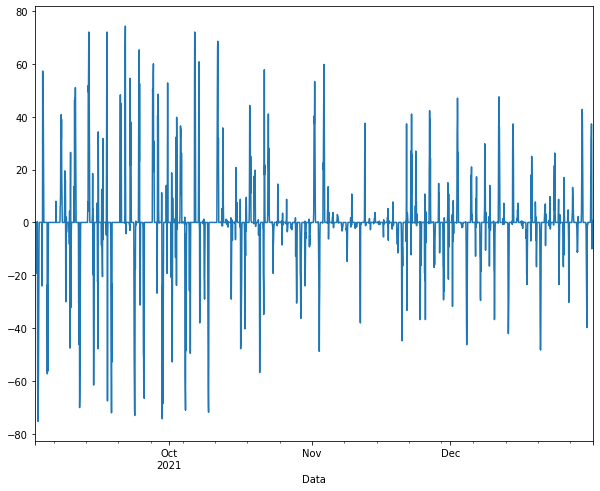

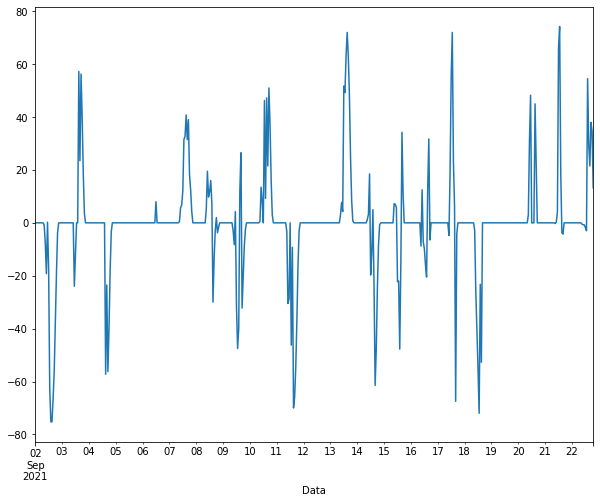

In [64]:
#  24th order diff
test = new_df
test['first_difference'] = test[' Produzida'].diff(24)
test = test.dropna()
test['first_difference'].plot()
plt.show()

test['first_difference'][:500].plot()
plt.show()

# Hurray! Less Seasonality!

In [65]:
adf_result = adfuller(test['first_difference'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# p-val = 4.0010382351396014e-22 < 0.05 - First Difference over a 24 hour period is stationary

ADF Statistic: -12.132555442654137
p-value: 4.0010382351396014e-22


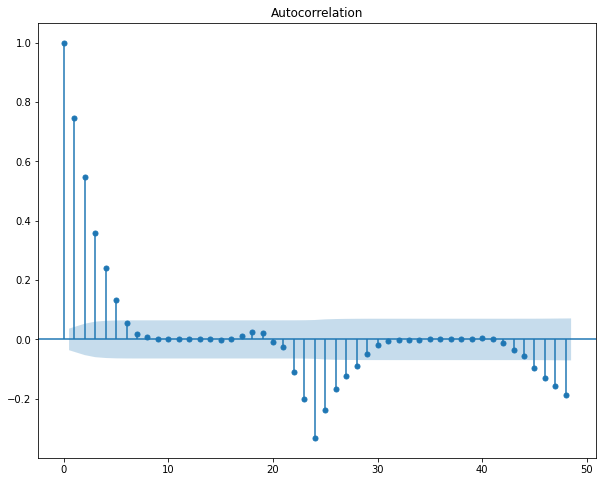

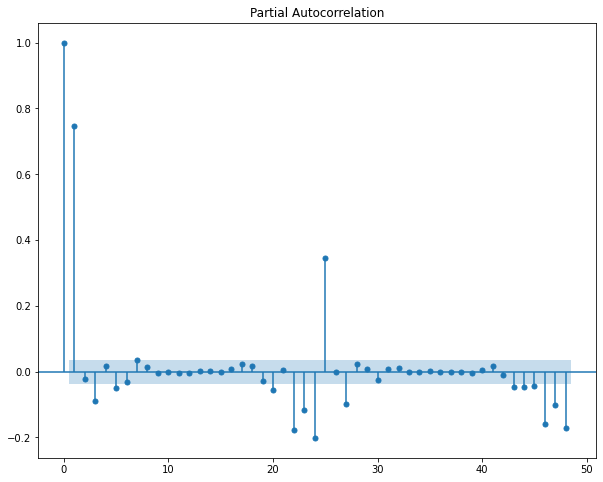

In [66]:
plot_acf(test['first_difference'], lags=48)
plt.show()

plot_pacf(test['first_difference'], lags=48)
plt.show()

# PACF has a peak at lag 1, so it suggests at least 1 AR(1) process, and along with ACF no MA process
# and seasonality terms (P,D,Q)
# Although these plots can give us a general idea of the processes,
# it's nice to choose a model that yield the lowest BIC and AIC (what does autoarima tells us?)

# Train Test Split

In [67]:
new_df = new_df.join(met_df['temp'], on='Data')

In [68]:
new_df = new_df.dropna()

In [69]:
train_df = new_df.loc[(new_df.index >= datetime(2021, 9, 1)) & (new_df.index < datetime(2021, 12, 25))][[' Produzida', 'temp']]
test_df = new_df.loc[(new_df.index >= datetime(2021, 12, 25)) & (new_df.index < datetime(2021, 12, 28))][[' Produzida', 'temp']]

In [70]:
print(train_df.shape, test_df.shape)

(2736, 2) (72, 2)


# Forecast Without Cross Validation

In [81]:
sarima_model = SARIMAX(train_df[' Produzida'], 
#                     exogenous=new_df[['temp']],
                    order=(1, 1, 0),
                    seasonal_order=(4,1,0,24))

# PACF tem um pico significativo (ignorar o pico do lag 0 - correlação do ponto por si mesmo) -> p = 1
# ACF decaimento geométrico - q = 0 / aplicar modelo arma
# Diferenciamos uma vez para tornar a série estacionária - I=1
####### Componente sazonal (A PARTIR DO LAG 20 NOS GRÁFICOS ACF E PACF) #######
# PACF tem 4 picos significativo a partir do lag 20 -> P = 4
# ACF geométrico a partir do lag 20 - Q = 0
# Diferenciamos uma vez para tornar a série estacionária - I=1
# Componente sazonal de 24 em 24 pontos - m=24

sarima_model_fit = sarima_model.fit()
predictions = sarima_model_fit.forecast(len(test_df))

C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [82]:
# SARIMA(p,d,q)(P,D,Q)m
# SARIMA(AR,I,MA)(Pico significativo sazonal PACF,I,Pico significativo sazonal ACF)m=24
# AR Picos significativo PACF
# MA Picos significativos ACF
# I - Ordem da operação de diferenciação para remover tendência e sazonalidade

In [83]:
sarima_residuals = sarima_model_fit.resid

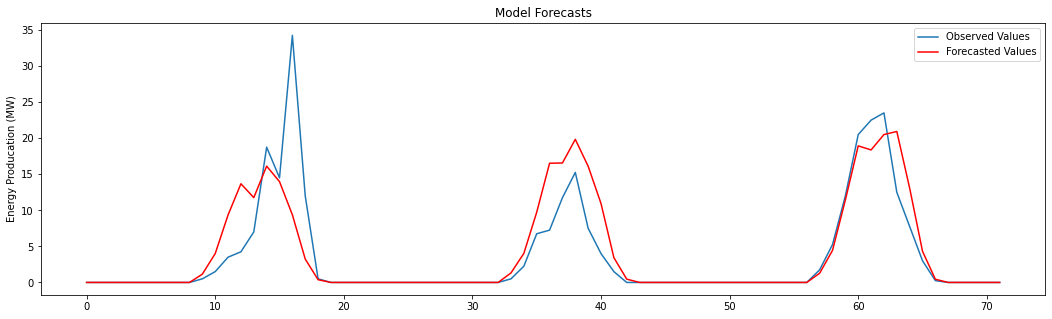

In [84]:
plt.plot(test_df[' Produzida'].values, label='Observed Values')
plt.plot(predictions.values, color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Producation (MW)')
plt.show()

In [85]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Produzida   No. Observations:                 2736
Model:             SARIMAX(1, 1, 0)x(4, 1, 0, 24)   Log Likelihood               -9466.402
Date:                            Fri, 09 Sep 2022   AIC                          18944.804
Time:                                    11:01:34   BIC                          18980.235
Sample:                                09-02-2021   HQIC                         18957.614
                                     - 12-24-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0781      0.009     -8.466      0.000      -0.096      -0.060
ar.S.L24      -0.7768      0.009    -86.788      0.000      -0.794      -0.759
ar.S.L48      -0.6629      0.012    -54.364      0.000      -0.687      -0.639
ar.S.L72      -0.4318      0.012    -35.556      0.000      -0.456      -0.408
ar.S.L96      -0.1910      0.010    -19.039      0.000      -0.211      -0.171
sigma2        62.6418      0.682     91.825      0.000      61.305      63.979
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             15030.19
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

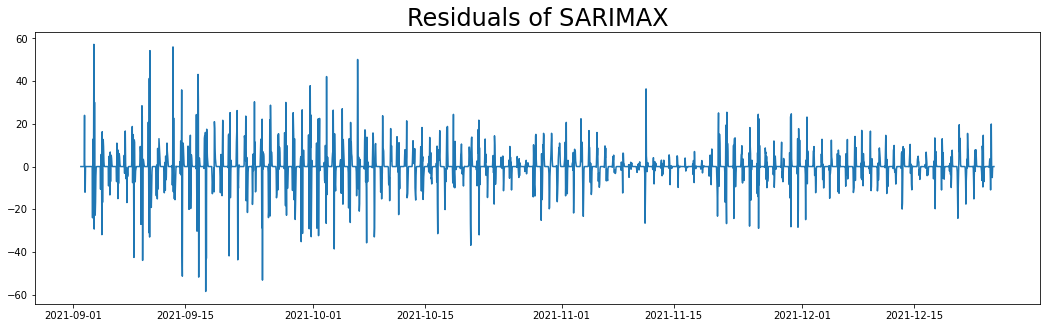

In [86]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX", size = 24)
plt.show()

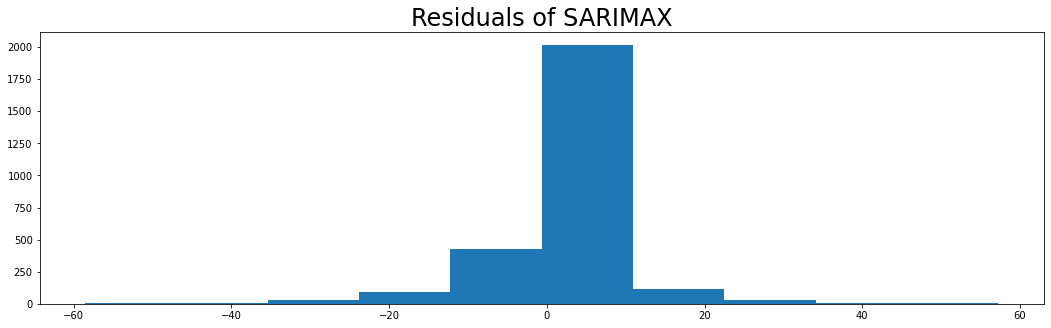

In [87]:
plt.rcParams["figure.figsize"] = 18, 5
plt.hist(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX", size = 24)
plt.show()

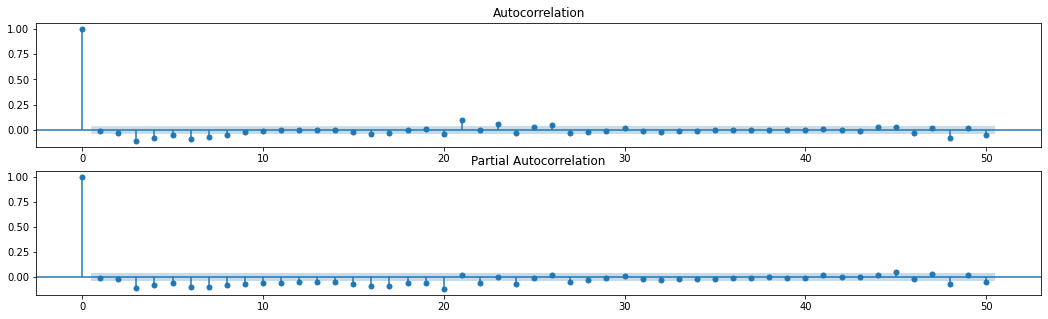

In [88]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(sarima_residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(sarima_residuals, lags=50, ax=ax[1])
plt.show()

In [140]:
rmse = mean_squared_error(test_df[' Produzida'], predictions.values, squared=False)
rmse

4.1749451914319735

In [141]:
mse = mean_squared_error(test_df[' Produzida'], predictions.values, squared=True)
mse

17.43016735146096

In [ ]:
# mean_squared_error - According to sklearn
# If True returns MSE value, if False returns RMSE value.